In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import sys 
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob

sys.path.append('../../src')

In [3]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3540
    obs: 'cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count'

In [5]:
for i in tqdm(glob.glob('/Users/koush/Downloads/perturbations/snrna_human_tonsil/*.parquet')):
    goi = i.split('/')[-1].split('.')[0]
    df = pd.read_parquet(i)
    adata.layers[f'{goi}'] = df.values

100%|██████████| 30/30 [00:05<00:00,  5.63it/s]


In [6]:
xy = xy_from_adata(adata)

In [7]:
adata.obs = adata.obs.join(pd.read_csv('/tmp/banksy_celltypes.csv', index_col=0))

In [8]:
color_dict = {
    'T_CD4': "#ea7465",
    'T_follicular_helper': "#b74329", 
    'T_CD8': "#dd3652",
    
    'GC Light Zone': "#e28723",
    'GC Intermediate Zone': "#5bbbdb",
    'GC Dark Zone': "#964ac6",
    
    'B_memory': "#61c17c",
    'B_naive': "#4b9131", 
    'plasma': "#beb637",
    
    'mDC/myeloid': "#c6ccc2",
    'FDC': "#79949a",
    'pDC': "#98907f"
}

alt_labels_dict = {
    'T_CD4': "T_CD4",
    'T_follicular_helper': "T_follicular_helper", 
    'T_CD8': "T_CD8",
    
    'GC Light Zone': "GC B Cells",
    'GC Intermediate Zone': "GC B Cells",
    'GC Dark Zone': "GC B Cells",
    
    'B_memory': "B Cells",
    'B_naive': "B Cells", 
    'plasma': "Plasma",
    
    'mDC/myeloid': "Myeloid",
    'FDC': "FDC",
    'pDC': "pDC"
}

alt_colors = {
    'T_CD4': color_dict['T_CD4'],
    'T_follicular_helper': color_dict['T_follicular_helper'],
    'T_CD8': color_dict['T_CD8'],
    'FDC': color_dict['FDC'],
    'pDC': color_dict['pDC'],
    'B Cells': 'limegreen',
    'GC B Cells': 'mediumpurple',
    'Plasma': color_dict['plasma'],
    'Myeloid': color_dict['mDC/myeloid'],
}

In [9]:
perturb_target = 'PRDM1'

delta_X = (adata.to_df(layer=perturb_target) - adata.to_df(layer='imputed_count')).values
gene_mtx = adata.layers['imputed_count']

# delta_X = np.random.normal(size=adata.layers['imputed_count'].shape)
# delta_X_shuffled = delta_X.copy()
# np.random.shuffle(delta_X_shuffled)

In [10]:
chart = Cartography(adata, color_dict)

In [11]:
%%time
corr = chart.get_corr(perturb_target)

CPU times: user 4min 28s, sys: 2min 32s, total: 7min 1s
Wall time: 1min 27s


In [12]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=7)
sc.tl.umap(adata, min_dist=0.5)

In [13]:
xy_umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    index=adata.obs_names, 
    columns=['x', 'y']
    ).join(adata.obs)

In [14]:
# f, ax = plt.subplots(figsize=(4, 4), dpi=100)
# sns.scatterplot(
#     data=xy.join(adata.obs),
#     x='x', y='y',
#     hue='alt_labels', 
#     s=50,
#     alpha=1,
#     edgecolor='black', 
#     linewidth=0.5,
#     palette=alt_colors,
#     ax=ax,
#     legend=True
# )
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# plt.show()

In [15]:
adata.obs['alt_labels'] = adata.obs.banksy_celltypes.replace(alt_labels_dict)

In [16]:
adata.layers

Layers with keys: imputed_count, normalized_count, GAS6, TGFBR3, IL7R, FLT3, ANGPTL1, IL15, PRDM1, CCR7, BMPR2, BACH2, IL7, IL21, CD40LG, IGF1, CCL5, IRF8, BCL6, IL6ST, IL27RA, CCL21, ITGB1, CXCR4, PAX5, FOXO1, FOXP1, CCL22, IL18, CXCL13, CR2, CXCR5

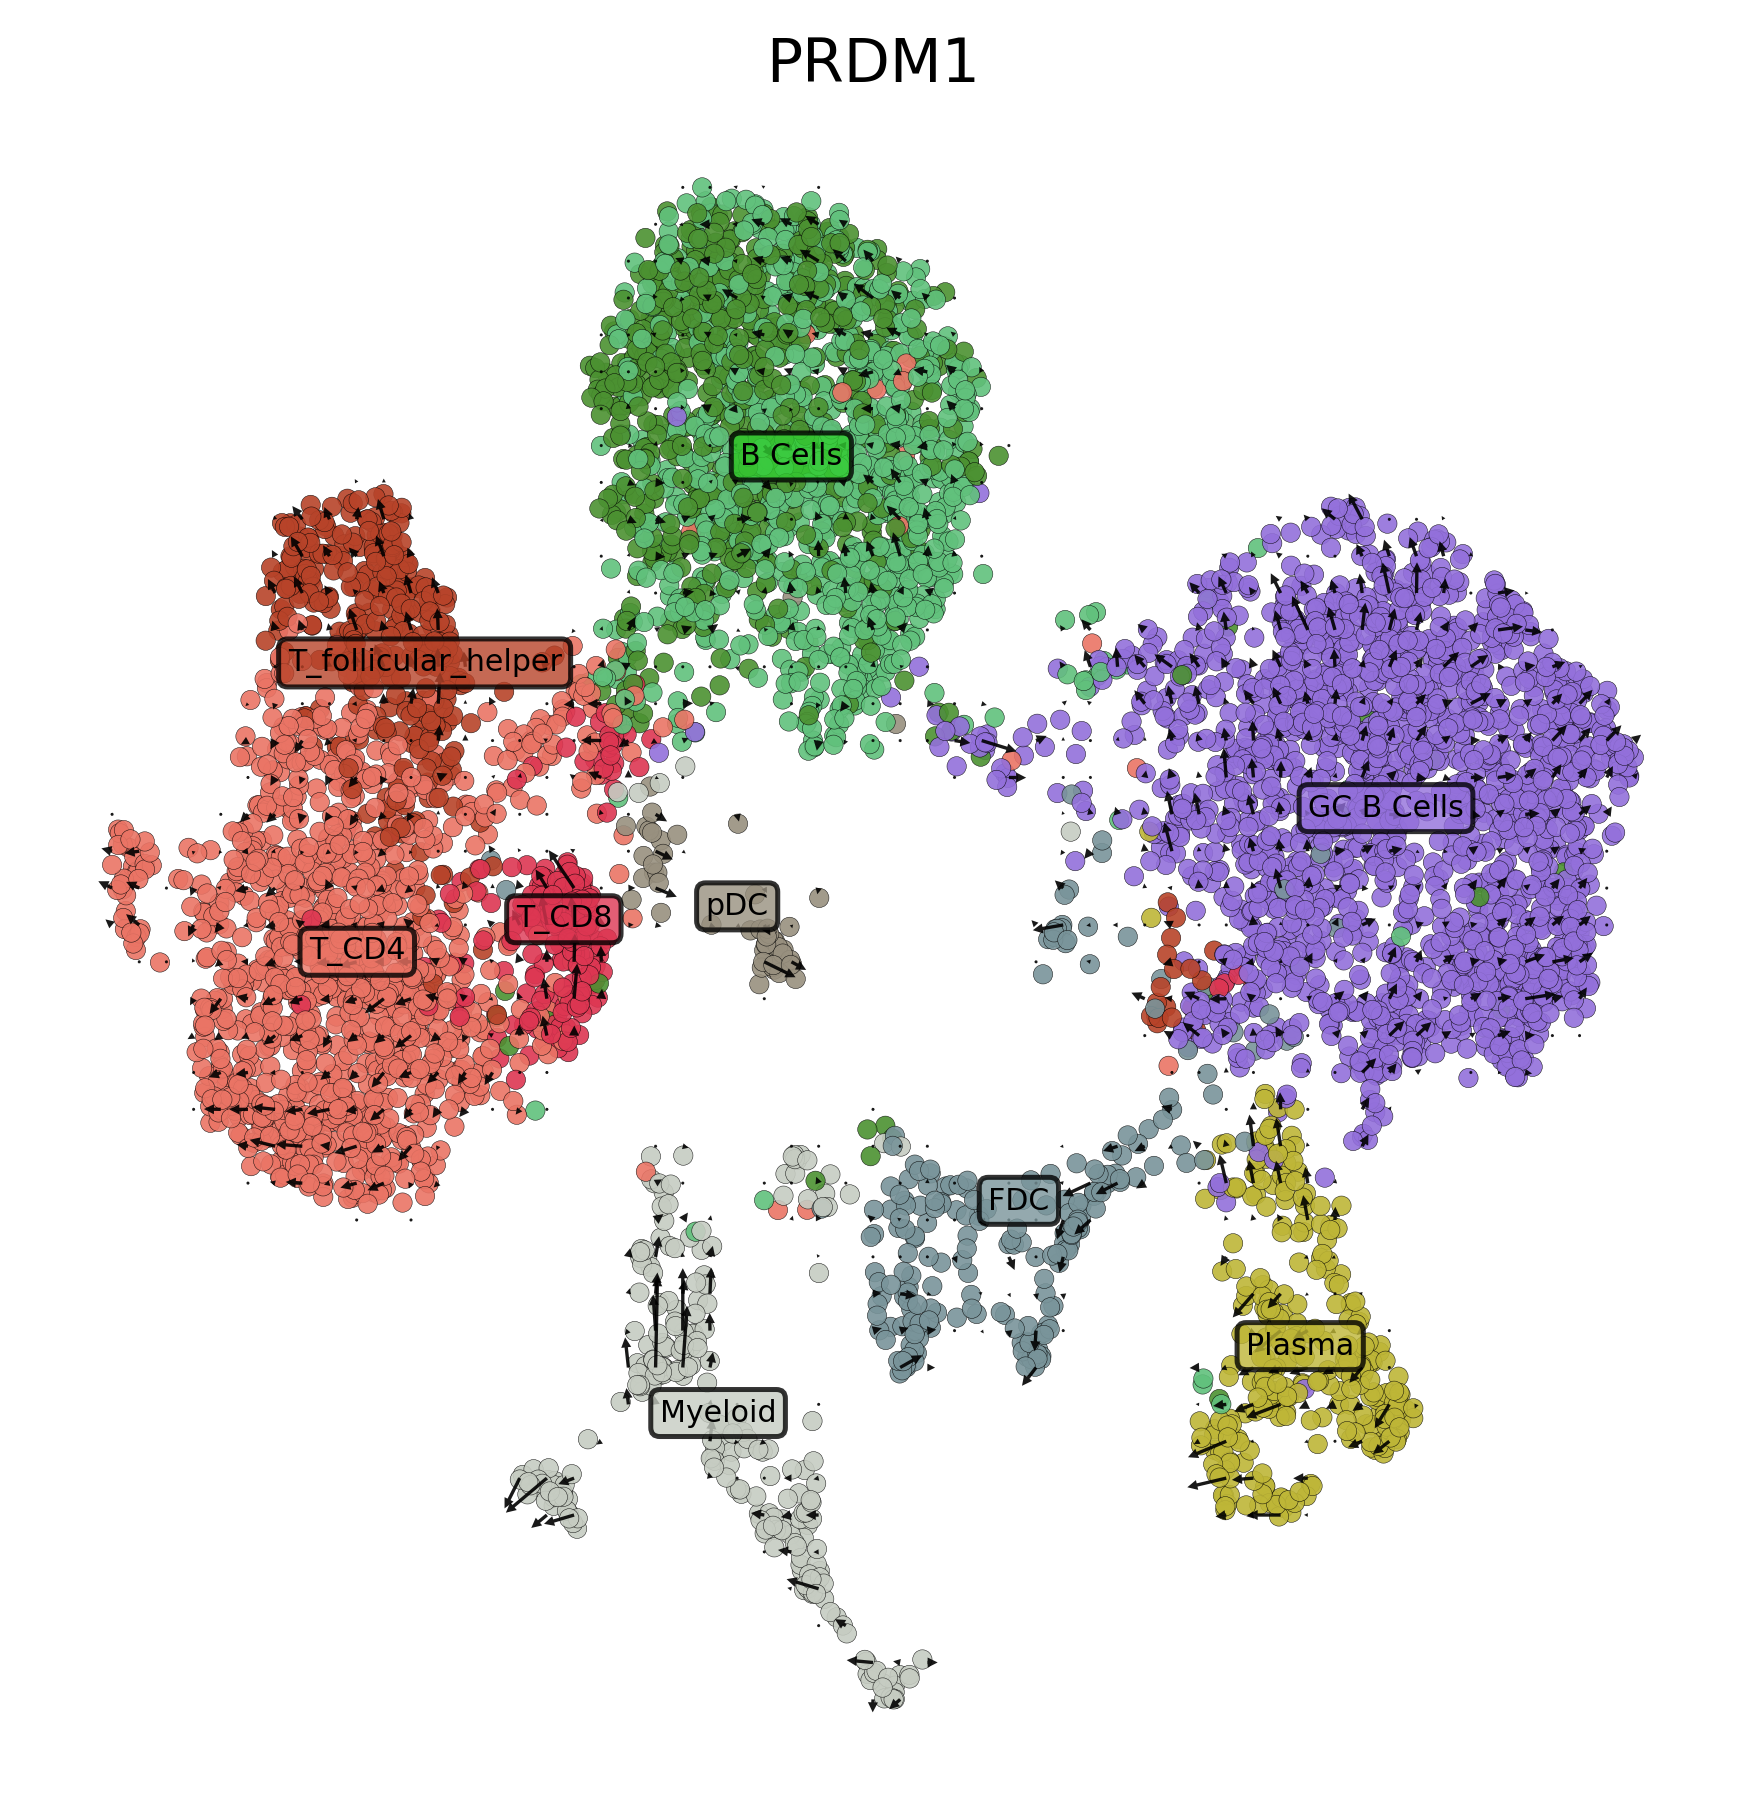

In [19]:
ax = chart.plot_umap_quiver(
    perturb_target=perturb_target,
    grid_scale=2,
    vector_scale=1,
    alt_colors=alt_colors,
    figsize=(6, 6), 
    # hue='transition'
)

plt.show()

In [20]:
from spaceoracle.plotting.shift import estimate_transition_probabilities

embedding = adata.obsm['X_umap']
n_neighbors = 200
delta_X = adata.layers[perturb_target] - adata.layers['imputed_count']
corr = chart.get_corr(perturb_target)
P = estimate_transition_probabilities(
    adata, delta_X, embedding, n_neighbors=n_neighbors, n_jobs=1)

In [23]:
adata.obs

cell_type cell_type_int banksy_celltypes  \
Plasma                                                                 
AAACCCAAGCGCCTTG-1              T_CD4             5            T_CD4   
AAACCCAAGTGGACGT-1             plasma            12           plasma   
AAACCCACAGAAGTGC-1  B_germinal_center             0    GC Light Zone   
AAACCCAGTCATTGCA-1            B_naive             2         B_memory   
AAACCCATCATCGCAA-1           B_memory             1         B_memory   
...                               ...           ...              ...   
TTTGTTGCAGGGACTA-1  B_germinal_center             0     GC Dark Zone   
TTTGTTGCATTGTAGC-1             plasma            12           plasma   
TTTGTTGGTACCACGC-1  B_germinal_center             0     GC Dark Zone   
TTTGTTGGTCTGTCCT-1              T_CD4             5            T_CD4   
TTTGTTGTCATGCGGC-1              T_CD4             5            T_CD4   

                    alt_labels  
Plasma                          
AAACCCAAGCGCCTTG-1       T_CD4  
AAACCCAAGTGGACGT-1      Plasma  
AAACCCACAGAAGTGC-1  GC B Cells  
AAACCCAGTCATTGCA-1     B Cells  
AAACCCATCATCGCAA-1     B Cells  
...                        ...  
TTTGTTGCAGGGACTA-1  GC B Cells  
TTTGTTGCATTGTAGC-1      Plasma  
TTTGTTGGTACCACGC-1  GC B Cells  
TTTGTTGGTCTGTCCT-1       T_CD4  
TTTGTTGTCATGCGGC-1       T_CD4  

[5778 rows x 4 columns]

In [70]:
source_ct = 'B_naive'
transition_df = chart.compute_transitions(corr, source_ct=source_ct)

In [71]:
chart.assess_transitions(
    transition_df, 
    base_celltypes=adata.obs.banksy_celltypes, 
    source_ct=source_ct
)

Source Cells: B_naive           min      mean       max
Transition Target                                      
B_naive                3.420945e-10  0.000699  0.001233
B_memory               2.023134e-10  0.000471  0.001060
pDC                    8.469155e-09  0.000053  0.010310
FDC                    4.030107e-10  0.000033  0.002592
T_CD4                  3.030271e-09  0.000030  0.000899
mDC/myeloid            1.258382e-09  0.000025  0.000575
T_CD8                  2.063119e-09  0.000024  0.003378
T_follicular_helper    2.426093e-10  0.000020  0.001501
GC Dark Zone           1.718281e-12  0.000008  0.000361
GC Light Zone          9.751556e-12  0.000007  0.000797
plasma                 8.685132e-12  0.000006  0.000128
GC Intermediate Zone   5.938835e-13  0.000006  0.000480

In [36]:
thresh = 0.00045 # need to cross this to leave base cell phenotype
allowed_fates = [
    # 'T_CD4',
    'plasma',
    'GC Light Zone',
    'B_memory',
    'GC Intermediate Zone',
    # 'T_follicular_helper',
    'GC Dark Zone',
    # 'FDC',
    'B_naive',
    # 'T_CD8',
    # 'mDC/myeloid',
    # 'pDC'
]

transitions = chart.get_cellfate(transition_df, allowed_fates, thresh)

100%|██████████| 274/274 [00:03<00:00, 84.11it/s]

Counter({'B_memory': 184, 'plasma': 70, 'GC Dark Zone': 17, 'B_naive': 2, 'GC Light Zone': 1}) 0.0004521653387598443


In [37]:
projection_params = {
    'basis': 'spatial',
    'color': 'banksy_celltypes', 
    'legend_loc': 'right',
    'recompute': True,
    'stream': False,
    'scale': 0.8,
    'alpha': 0.6,
    'size': 50,
    'show': False,
    'linewidth': 0.1,
    'palette': color_dict,
    'min_mass': 50,
    'smooth': 1.0,
    'edgecolor': 'none',
    'arrow_color':'black',
    'n_neighbors': 100,
}

In [38]:
%%capture
X_grid, V_grid = chart.get_grids(P, projection_params)
vector_field_df = chart.vector_field_df(X_grid, V_grid)


In [39]:
import alphashape

In [40]:
source_cells = adata.obs[adata.obs['banksy_celltypes'] == source_ct].index

In [41]:
adata.obs['transition'] = adata.obs['banksy_celltypes'].copy()
adata.obs.loc[source_cells, 'transition'] = np.array(transitions)
ct_points_wt, ct_points_ko = chart.make_celltype_dict()

In [42]:
delta_df = adata.to_df(layer='FOXO1') - adata.to_df(layer='imputed_count')


In [44]:
alpha_shape_1 = alphashape.alphashape(ct_points_wt['GC Light Zone'], alpha=0.04)
alpha_shape_2 = alphashape.alphashape(ct_points_wt['GC Dark Zone'], alpha=0.04)
alpha_shape_3 = alphashape.alphashape(ct_points_wt['GC Intermediate Zone'], alpha=0.04)

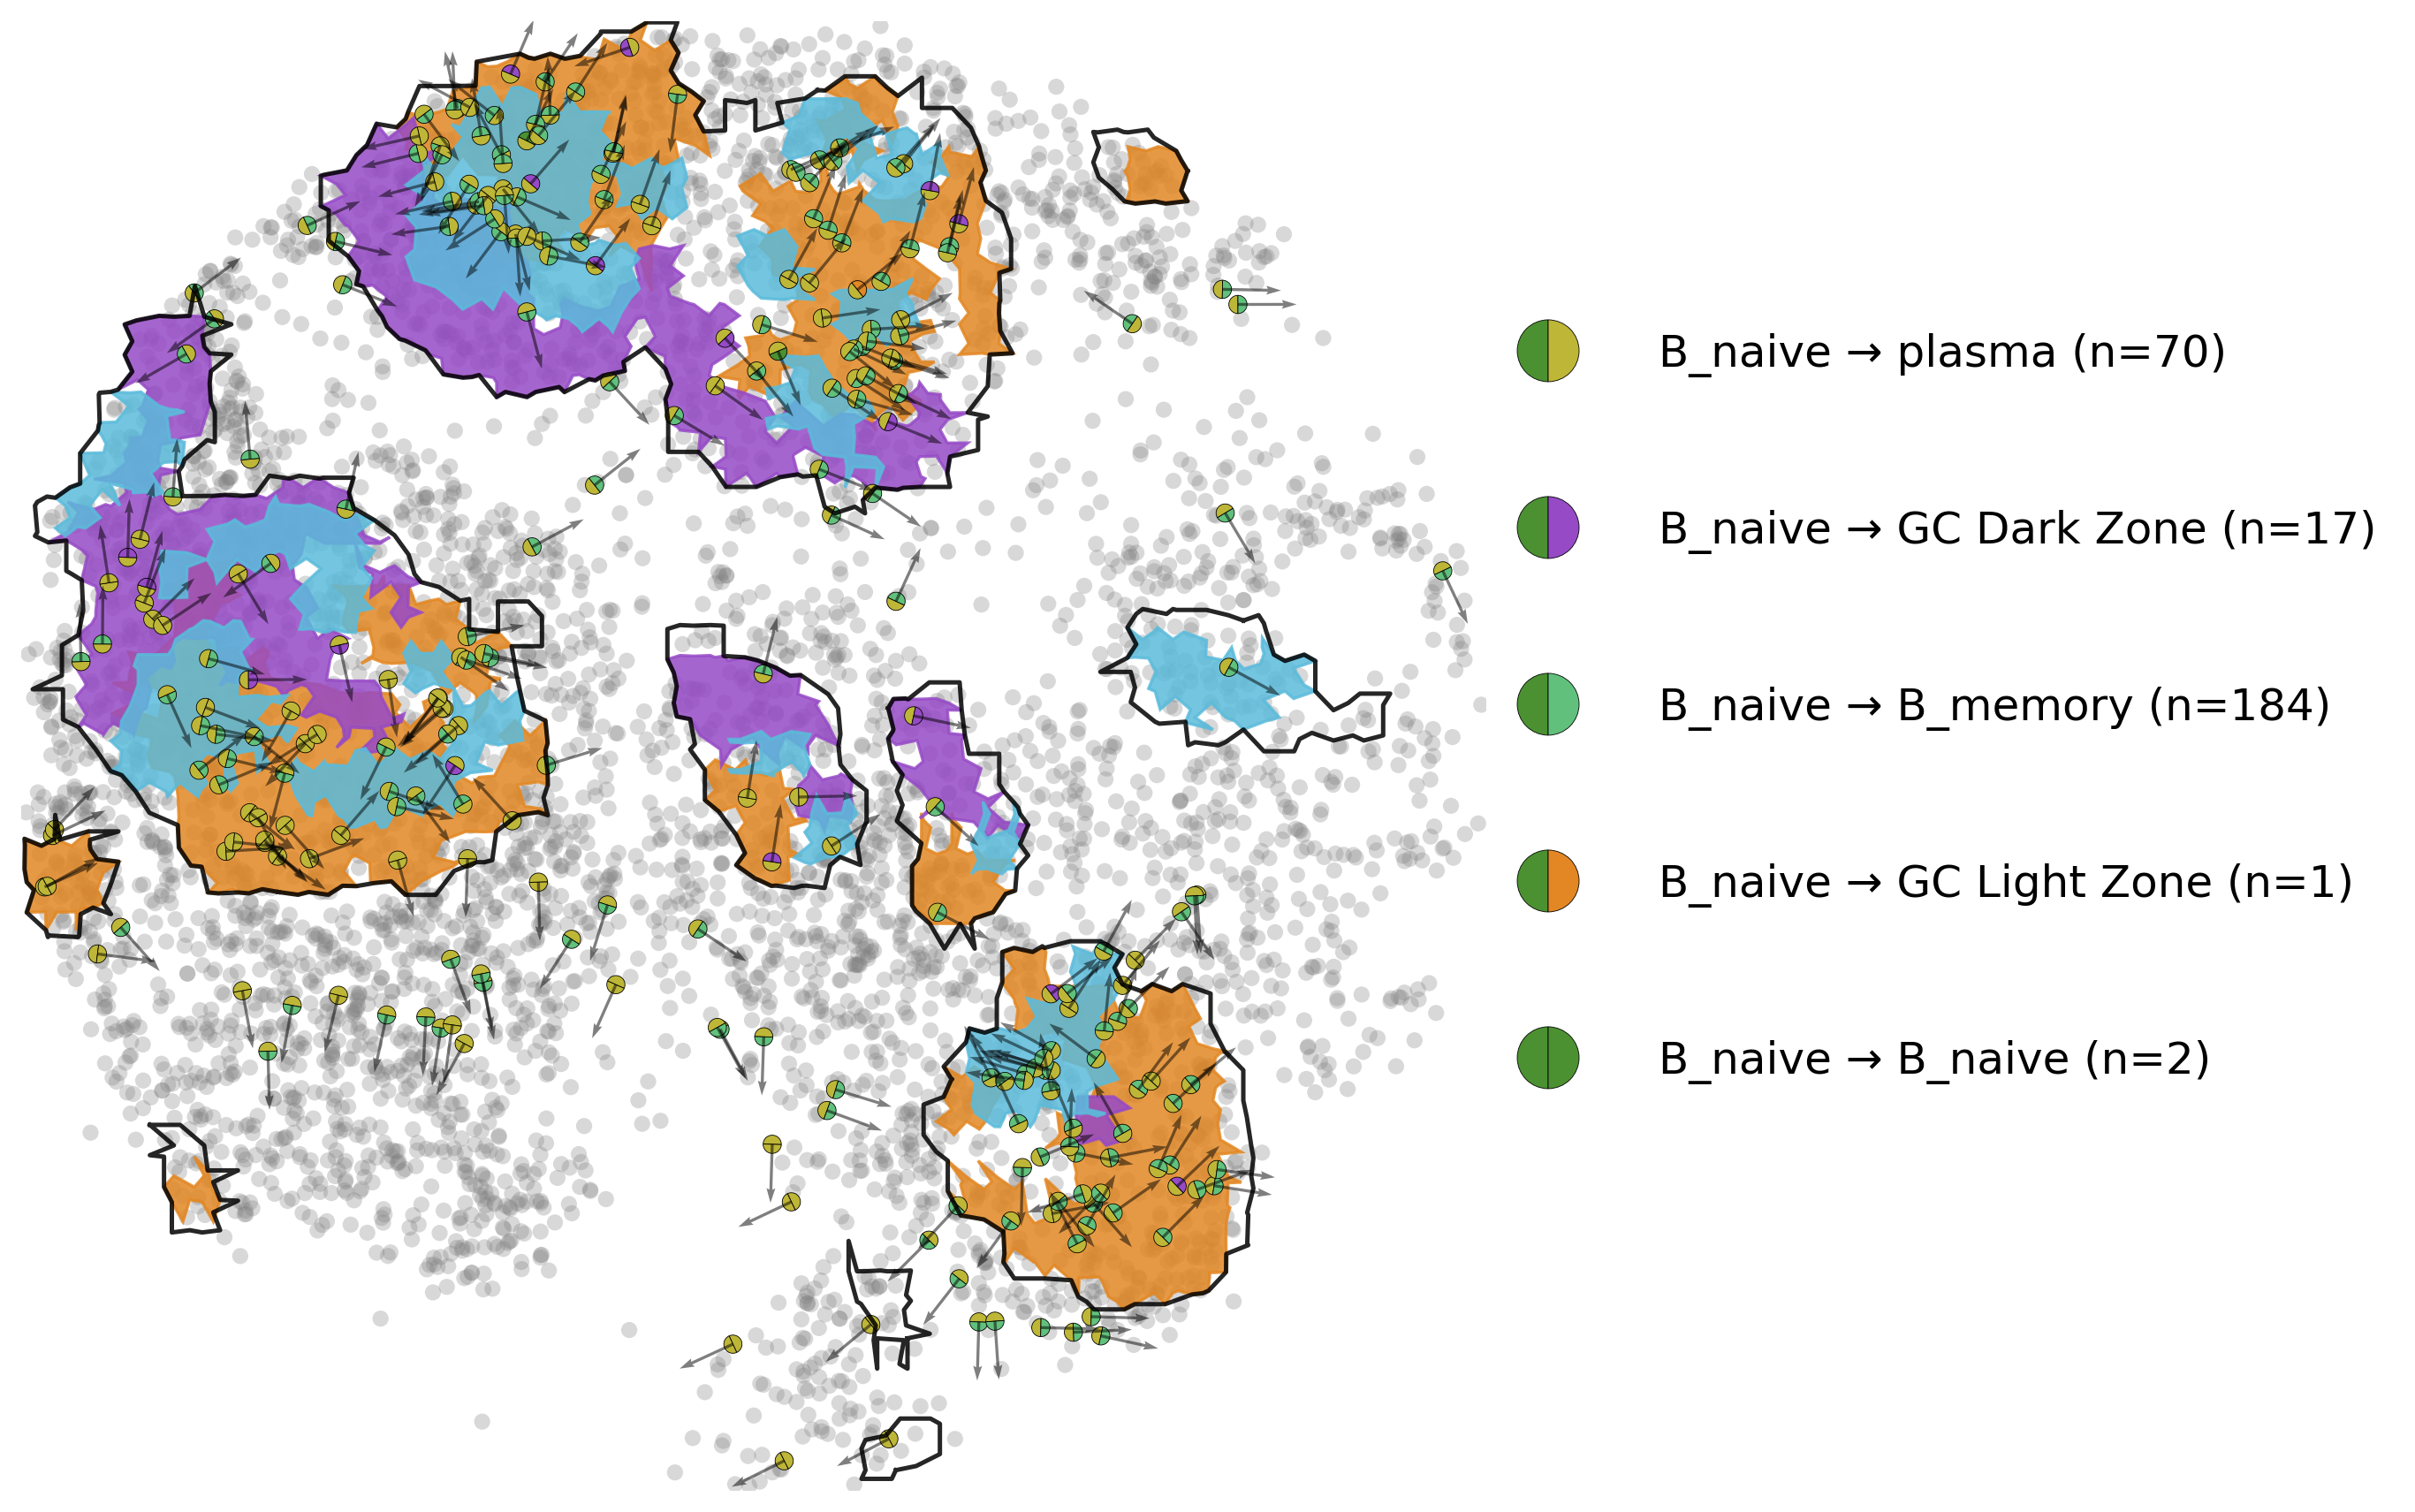

In [83]:
from matplotlib.legend_handler import HandlerTuple
import matplotlib
# Custom handler for wedge pairs in legend
class WedgePairHandler:
    def __init__(self, rotation=0):
        self.rotation = rotation
        
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        r = min(width, height) * 1
        center = (x0 + width/2, y0 + height/2)
        
        # Create left and right wedges with rotation
        wedge1 = matplotlib.patches.Wedge(
            center=center,
            r=r,
            theta1=90 + self.rotation, theta2=270 + self.rotation,
            facecolor=orig_handle[0].get_facecolor(),
            edgecolor='black',
            linewidth=0.25,
            transform=handlebox.get_transform()
        )
        
        wedge2 = matplotlib.patches.Wedge(
            center=center,
            r=r,
            theta1=-90 + self.rotation, theta2=90 + self.rotation,
            facecolor=orig_handle[1].get_facecolor(),
            edgecolor='black', 
            linewidth=0.25,
            transform=handlebox.get_transform()
        )
        
        handlebox.add_artist(wedge1)
        handlebox.add_artist(wedge2)
        return [wedge1, wedge2]

fig, ax = plt.subplots(figsize=(20, 9), dpi=120)
data = xy.join(adata.obs)
source_data = data[data.banksy_celltypes == source_ct]
transition_data = data.loc[source_cells]

scatter = sns.scatterplot(
    data=xy.join(adata.obs),
    x='x', y='y',
    # hue='banksy_celltypes', 
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    # palette=color_dict,
    ax=ax,
)



zone_alpha = 0.85
for geom in alpha_shape_1.geoms:
    if geom.area > 5000:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

for geom in alpha_shape_2.geoms:
    if geom.area > 5000:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['GC Dark Zone'], alpha=zone_alpha)

for geom in alpha_shape_3.geoms:
    if geom.area > 5000:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

alpha_shape_4 = alphashape.alphashape(
    np.concatenate(
        [ct_points_wt['GC Light Zone'], 
         ct_points_wt['GC Intermediate Zone'], 
         ct_points_wt['GC Dark Zone']]
        ), alpha=0.03)

for geom in alpha_shape_4.geoms:
    if geom.area > 10000:
        ax.plot(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color='black', alpha=zone_alpha)

# Create scatter plot with legend



    
radius = 18

angles = vector_field_df.angle

for idx, row in data.iterrows():
    if idx in source_cells:
        angle = angles[idx]
        circle1 = matplotlib.patches.Wedge((row.x, row.y), radius, 90+angle, 270+angle,
                                         facecolor=color_dict[row.banksy_celltypes],
                                         alpha=1,
                                         edgecolor='black', linewidth=0.25)
        circle2 = matplotlib.patches.Wedge((row.x, row.y), radius, -90+angle, 90+angle,
                                         facecolor=color_dict[row.transition],
                                         alpha=1,
                                         edgecolor='black', linewidth=0.25)
        ax.add_patch(circle1)
        ax.add_patch(circle2)
    else:
        continue
        circle = plt.Circle((row.x, row.y), radius=radius//1.5,
                          facecolor='grey',
                          alpha=0.5,
                          edgecolor='none') 
        ax.add_patch(circle)
# for ii, jj in edges:
#     ax.plot(
#         points[[ii, jj], 0], 
#         points[[ii, jj], 1], 'k', 
#         linewidth=1, alpha=0.65, 
#         linestyle='--', color='red')

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
ax.set_ylim(data.y.min() - 10, data.y.max() + 10)

# Collect all unique transition types from transition_data
unique_transitions = transition_data['transition'].unique()

# Create legend elements for each transition type
legend_elements = []
labels = []

# Create legend elements with fixed angles for consistent appearance
for transition in unique_transitions:
    # Count number of transitions for this type
    n_transitions = len(transition_data[transition_data['transition'] == transition])
    
    wedge_source = matplotlib.patches.Wedge((0,0), radius, 0, 0,
                                          facecolor=color_dict[source_ct])
    wedge_transition = matplotlib.patches.Wedge((0,0), radius, 0, 0,
                                              facecolor=color_dict[transition])
    legend_elements.append((wedge_source, wedge_transition))
    labels.append(f"{source_ct} → {transition} (n={n_transitions})")

# Create the transitions legend using custom handler with 45 degree rotation
transition_legend = ax.legend(legend_elements, labels, 
                            handler_map={tuple: WedgePairHandler(rotation=0)},
                            bbox_to_anchor=(1, 0.8), 
                            # loc='center right', 
                            borderaxespad=0.,
                            fontsize=15,
                            markerscale=5,
                            labelspacing=3,
                            handletextpad=1.5, 
                            frameon=False,
                            title="")


# sns.scatterplot(
#     data=vector_field_df.join(adata.obs).query(
#         'cell_type == "B_germinal_center"'), 
#     x='x', y='y', s=50, 
#     hue='banksy_celltypes', palette=color_dict, legend=False, ax=ax)

vecdf = vector_field_df.join(adata.obs).query(
    'banksy_celltypes == "plasma"')

magn = np.sqrt(V_grid[:, 0]**2 + V_grid[:, 1]**2)

ax.quiver(vecdf['x'], vecdf['y'], 
          np.cos(np.radians(vecdf['angle'])), 
          np.sin(np.radians(vecdf['angle'])),
          scale=25, width=0.002, alpha=0.5)

# q = plt.quiver(X_grid[:, 0], X_grid[:, 1], V_grid[:, 0], V_grid[:, 1],
#             #    magnitudes, 
#                cmap='magma', 
#                linewidth=0.4,
#                scale=1000, width=0.0035, 
#                alpha=0.4, edgecolor=None)

plt.xlabel('')
plt.ylabel('')
plt.title('')

# plt.tight_layout()
# plt.savefig('/tmp/transition_figure.png', dpi=300, format='png')
plt.show()

# scatter_legend = ax.legend(
#     title="Cell Types", bbox_to_anchor=(1.5, -0.0), 
#     loc='lower right', markerscale=2)

# for lh in scatter_legend.legend_handles:
#     lh.set_alpha(1)
# ax.add_artist(scatter_legend)


In [212]:
# fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
# data = xy.join(adata.obs)
# source_data = data[data.banksy_celltypes == source_ct]
# transition_data = data.loc[source_cells]

# scatter = sns.scatterplot(
#     data=xy.join(adata.obs),
#     x='x', y='y',
#     # hue='banksy_celltypes', 
#     color='grey',
#     s=30,
#     alpha=0.3,
#     edgecolor='none',
#     # palette=color_dict,
#     ax=ax,
# )

# alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.04)
# alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.04)
# alpha_shape_3 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.04)

# zone_alpha = 0.85
# for geom in alpha_shape_1.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

# for geom in alpha_shape_2.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Dark Zone'], alpha=zone_alpha)

# for geom in alpha_shape_3.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

# alpha_shape_4 = alphashape.alphashape(
#     np.concatenate(
#         [ct_points_wt['GC Light Zone'], 
#          ct_points_wt['GC Intermediate Zone'], 
#          ct_points_wt['GC Dark Zone']]
#         ), alpha=0.03)

# for geom in alpha_shape_4.geoms:
#     if geom.area > 10000:
#         ax.plot(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color='black', alpha=zone_alpha)

# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_aspect('equal')
# ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
# ax.set_ylim(data.y.min() - 10, data.y.max() + 10)
# plt.show()